## Exercise 3 - UK tree arthropods metabarcoding ##

In this exercise we will use [metaBEAT](https://github.com/HullUni-bioinformatics/metaBEAT), a tool tailored towards reproducible and efficient analyses of metabarcoding data that we have developed in-house. It is still under active development and will likely be extended further in the future. The pipeline is available in a Docker [container](https://registry.hub.docker.com/u/chrishah/metabeat/) with all necessary dependencies. The Docker image is building on [ReproPhylo](https://registry.hub.docker.com/u/szitenberg/reprophylo/).

The pipeline offers a large number of options. Some of them will sound familiar and should make sense to you given your experience from the course so far.

In [1]:
!metaBEAT_global.py -h

usage: metaBEAT.py [-h] [-Q <FILE>] [-B <FILE>] [--g_queries <FILE>] [-v] [-s]
                   [-f] [-p] [-k] [-t] [-b] [-m <string>] [-n <INT>] [-E] [-e]
                   [--read_stats_off] [--PCR_primer <FILE>]
                   [--trim_adapter <FILE>] [--trim_qual <INT>] [--phred <INT>]
                   [--trim_window <INT>] [--read_crop <INT>]
                   [--trim_minlength <INT>] [--merge] [--product_length <INT>]
                   [--merged_only] [--forward_only] [--length_filter <INT>]
                   [--length_deviation <FLOAT>] [-R <FILE>] [--gb_out <FILE>]
                   [--rec_check] [--gi_to_taxid <FILE>] [--cluster]
                   [--clust_match <FLOAT>] [--clust_cov <INT>]
                   [--blast_db <PATH>] [--blast_xml <PATH>]
                   [--min_ident <FLOAT>] [--min_ali_length <FLOAT>]
                   [--min_bit <INT>] [--refpkg <DIR>] [--jplace <FILE>]
                   [--kraken_db <DIR>] [--rm_kraken_db] [-o OUTPUT_PREFIX]
   

Minimum input for an anlysis is a set of query sequences in one or several files (accepted are a number of file formats, e.g. fasta, fastq). These will be run through the pipeline sequentially.

You will need to provide information on the nature and location of the query sequence files in a separate tab-delimited text files via the -Q flag. We have prepared the reads for you in the directory `READS`.

Each line in this text file should look as follows:
```
unique sample_ID <tab> format <tab> file1 <tab> file2
```

An example can be found [here](https://github.com/HullUni-bioinformatics/egrep-2016/blob/master/data/exercise-3/Queryfile_example.txt).

You may generate the required text files in any text editor - e.g. nano in a terminal.

You could call your samples anything, but we suggest that you use sample names that match the filenames of the Illumina data that you have downloaded before. See also the sample [metadata](https://github.com/HullUni-bioinformatics/egrep-2016/blob/master/data/metadata/2014_tree_metadata.csv) that we've provided.

Example line:
```
THB_BET    fastq    ./READS/THB_BET_1.fastq.gz   ./READS/THB_BET_2.fastq.gz
...
...
```

For the sake of reproducibility and because it's (arguably) much easier, you can also use your command line skills or write a simple program that will generate the required file.

In the cell below we produce it using a simple python script.
The script will list all files in the location to which we've placed the Illumina data (specified via the 'datadir' variable. It assumes that there is a file ending in `_1.fastq` for each sample. For each such file, it will extract the sample name from the filename and format the required line for the text file accordingly. We call the resulting file `Querymap.txt` (specified in the 'to' variable).

See if you can find your own solution using your command line skills.

In [2]:
import os

datadir = './READS/'
to = 'Querymap.txt'

####################
out_list = []
string = ''
files = os.listdir(datadir)
for f in sorted(files):
    if '_1.fastq' in f:
        string += "%s\tfastq\t%s%s\t%s/%s" %(f.replace('_1.fastq.gz', ''), datadir, f, datadir, f.replace('_1.fastq', '_2.fastq'))+'\n'

out = open(to, 'w')
out.write(string)
out.close()

Have a look (note that the output may be line-wrapped).

In [3]:
!head Querymap.txt

AHA_ASH	fastq	./READS/AHA_ASH_1.fastq.gz	./READS//AHA_ASH_2.fastq.gz
AHA_BEE	fastq	./READS/AHA_BEE_1.fastq.gz	./READS//AHA_BEE_2.fastq.gz
AHA_BET	fastq	./READS/AHA_BET_1.fastq.gz	./READS//AHA_BET_2.fastq.gz
AHA_HAZ	fastq	./READS/AHA_HAZ_1.fastq.gz	./READS//AHA_HAZ_2.fastq.gz
AHA_OAK	fastq	./READS/AHA_OAK_1.fastq.gz	./READS//AHA_OAK_2.fastq.gz
AHB_ASH	fastq	./READS/AHB_ASH_1.fastq.gz	./READS//AHB_ASH_2.fastq.gz
AHB_BEE	fastq	./READS/AHB_BEE_1.fastq.gz	./READS//AHB_BEE_2.fastq.gz
AHB_BET	fastq	./READS/AHB_BET_1.fastq.gz	./READS//AHB_BET_2.fastq.gz
AHB_OAK	fastq	./READS/AHB_OAK_1.fastq.gz	./READS//AHB_OAK_2.fastq.gz
AHC_ASH	fastq	./READS/AHC_ASH_1.fastq.gz	./READS//AHC_ASH_2.fastq.gz


__Now__, we will be perform basic quality trimming and clipping (Trimmomatic), paired-end read merging (flash) and read clustering at 97 % identity (vsearch), essentially as you did in the previous exercise. Only this time we will be using our custom pipeline metaBEAT to process all 39 samples in one go.

In addition to the `Querymap.txt` file that contains the location of the input fastq data we specify a fasta file containing the PCR primer sequences that were used to amplify the fragments. We want these to be removed from the sequences to only retain the actual biological sequence. We also provide a bunch of options affecting the trimming, merging and clustering procedures that may make some intuitive sense for you by now.

You will also have to provide an email address via the `-@` flag. The pipeline is desigend to automatically communicate with Genbank and the NCBI expects that you identify yourself so that they can get in touch in case there is a problem with your query.

See the below command:

In [ ]:
%%bash

echo -e "Starttime: $(date)\n"

metaBEAT_global.py \
-Q Querymap.txt \
--PCR_primer PCR_primers.fasta \
--trim_qual 30 --trim_minlength 100 \
--merge --product_length 350 --merged_only \
--cluster --clust_match 0.97 --clust_cov 3 \
--length_filter 313 --length_deviation 0.10 \
-m COI -o COI-trim30min100-merge-c3-id97 \
-n 5 -@ your.mail@email.com &> metaBEAT-c97.log

echo -e "Endtime: $(date)\n"

Some more details about the above command:

```bash
metaBEAT_global.py \ #call the program
-Q Querymap.txt \ #path to the Querymap
-_PCR_primer PCR_primers.fasta \ #fasta file containing the PCR primer sequences used for amplification
--trim_qual 30 \ #minimum quality for trimming is prhed Q30 (trimmomatic)
--trim_minlength 100 \ #only retain reads longer than 100 bp after trimming
--merge \ #merge overlapping read pairs (flash)
--merged_only \ #retain only reads for which forward and reverse reads were sucessfully merged
--product_length 350 \ #expected length of merged read is roughly 350 bp
--cluster \ #cluster sequences (vsearch)
--clust_match 0.97 \ #cluster at 100 % identity
--clust_cov 3 \ #minimum coverage of 3 reads to retain cluster
--length_filter 313 \ #expected product length after trimming
--length_deviation 0.10 \ #acceptable length deviation from expected length
-m COI \ #name of the marker gene (arbitrary)
-o COI-trim30min100-merge-c3-id97 \ #prefix for results files
-n 5 \ #use 5 threads
-@ your.mail@email.com \ #provide your email address


```

__Well Done__ if you got it running without errors. Each sample contains up to several 100k reads so the process will take a few hours (overnight).

metaBEAT will generate a directory with all temporary files that were create during the processing for each sample. The details of all processing steps that the pipeline performs are written to the file `metaBEAT-c97.log`.

The final denovo OTU table will be placed in a directory `GLOBAL` in two different formats:
```bash
GLOBAL/COI-trim30min100-merge-c3-id97-OTU-denovo.biom 
GLOBAL/COI-trim30min100-merge-c3-id97-OTU-denovo.tsv #human readable

```
The table will look roughly like [this](https://github.com/HullUni-bioinformatics/egrep-2016/blob/master/data/exercise-3/results_backup/COI-trim30min100-merge-c3-id97-OTU-denovo.tsv). We will add taxonomic assignments and some metadata to these tables at a later stage.


Useful stats summarizing the data processing will be recorded in the file `COI-trim30min100-merge-c3-id97_read_stats.csv`. Will look roughly like [this](https://github.com/HullUni-bioinformatics/egrep-2016/blob/master/data/exercise-3/results_backup/COI-trim30min100-merge-c3-id97_read_stats.csv).

You could explore the table manually or we could make full use of our Jupyter noteook and quickly plot out some of these stats directly here in the notebook, e.g. like so:

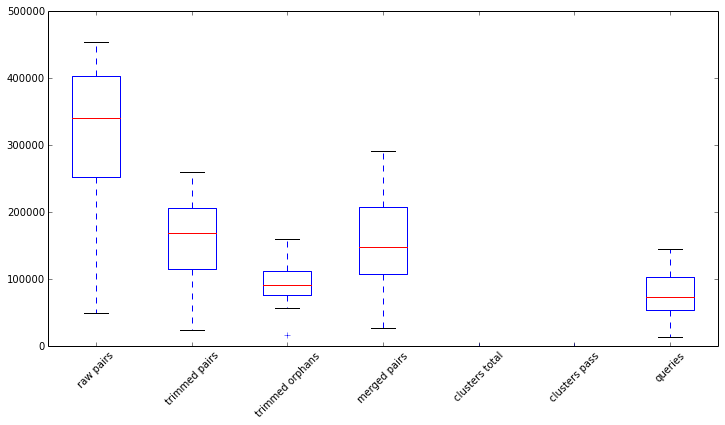

In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# parse metaBEAT_read_stats.csv
stats_file = 'COI-trim30min100-merge-c3-id97_read_stats.csv'

################
## prepare data
total_pairs = []
trimmed_pairs = []
trimmed_orphams = []
merged_pairs = []
clusters_total = []
clusters_ok = []
queries = []

for l in open(stats_file, 'r').readlines()[1:]:
    smpl, tot, trimtot, trimpe, trimorph, merged, n1,n2,n3,n4, q = l.rstrip().split(',')
    total_pairs.append(int(tot)/2.0)
    trimmed_pairs.append(int(trimpe)/2.0)
    trimmed_orphams.append(int(trimorph))
    merged_pairs.append(int(merged))
    clusters_total.append(int(n2))
    clusters_ok.append(int(n4))
    queries.append(int(q))
    
    
dat = [total_pairs, trimmed_pairs, trimmed_orphams, merged_pairs, clusters_total, clusters_ok, queries]
dat = [np.array(d) for d in dat]
x = ['raw pairs', 'trimmed pairs', 'trimmed orphans', 'merged pairs', 'clusters total', 'clusters pass', 'queries']

################
## do the plotting
fig = plt.figure(1, figsize=(12, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(dat)
bp = ax.set_xticklabels(x, rotation=45)

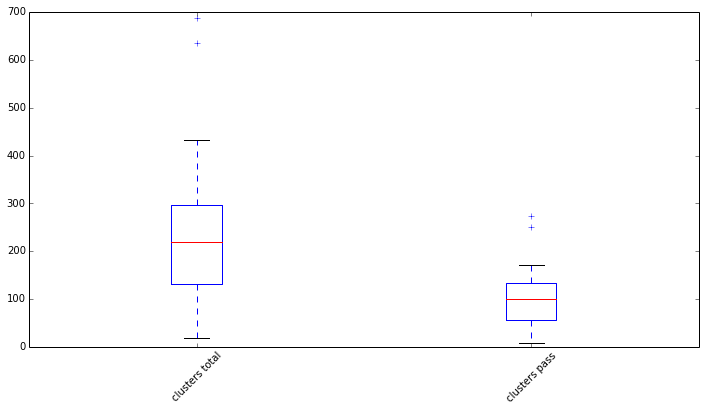

In [6]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


####
dat = [clusters_total, clusters_ok]
dat = [np.array(d) for d in dat]
x = ['clusters total', 'clusters pass']

fig = plt.figure(1, figsize=(12, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(dat)
bp = ax.set_xticklabels(x, rotation=45)